In [226]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [228]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/output.csv')

<ipython-input-4-14b04c33aebc>:1: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/drive/MyDrive/output.csv')


In [ ]:
df.shape

(15184, 227)

In [ ]:
df = df.drop_duplicates()
df = df.drop(df[df['Rjb_km'] == -999 ].index)
df = df.drop(df[df['Rjb_km'] > 1500 ].index)
df = df.drop(df[df['Rjb_km'] == -999 ].index)
# df = df.drop(df[df['HypD (km)'] <= 0 ].index)

In [229]:
df.head()

,NGAsubRSN,DatabaseRegion,NGAsubEQID,NGAsubSSN,Earthquake_Name,YEAR,MODY,HRMN,Earthquake_Magnitude,Hypocenter_Latitude_deg,...,T10pt000S,T11pt000S,T12pt000S,T13pt000S,T14pt000S,T15pt000S,T20pt000S,log Rjb,regionFlag,Magnitude_Range
0,1000002,Alaska,1000001,1000002,Aleutian_Isl-Alaska,2014,623,2053,7.96,51.6928,...,0.000390,0.000336,0.000332,0.000263,0.000215,0.000187,0.000119,2.609872,1,7-8
1,1000008,Alaska,1000001,1000008,Aleutian_Isl-Alaska,2014,623,2053,7.96,51.6928,...,0.000196,0.000187,0.000199,0.000218,0.000237,0.000216,0.000084,2.888727,1,7-8
2,1000040,Alaska,1000003,1000008,3316471,2011,624,309,7.28,51.9805,...,0.000413,0.000460,0.000355,0.000286,0.000223,0.000158,0.000070,2.293457,1,7-8
3,1000056,Alaska,1000004,1000008,2587660,2007,1219,930,7.21,51.3510,...,0.000093,0.000124,0.000125,0.000148,0.000138,0.000164,0.000172,2.858969,1,7-8
4,1000069,Alaska,1000005,1000005,4224881,2013,830,1625,7.00,51.6230,...,0.000033,0.000030,0.000037,0.000039,0.000045,0.000049,0.000041,2.925235,1,7-8


In [ ]:
df['log Rjb'] = np.log10(df['Rjb_km'])

In [ ]:
d = {}
i = 1
for row in df['DatabaseRegion']:
  if row not in d:
    d[row] = i
    i += 1

In [ ]:
d

{'Alaska': 1,
 'Cascadia': 2,
 'CentralAmerica&Mexico': 3,
 'Japan': 4,
 'SouthAmerica': 5,
 'Taiwan': 6}

In [ ]:
df['regionFlag'] = df['DatabaseRegion'].map(d)

In [ ]:
df.columns

Index(['NGAsubRSN', 'DatabaseRegion', 'NGAsubEQID', 'NGAsubSSN',
       'Earthquake_Name', 'YEAR', 'MODY', 'HRMN', 'Earthquake_Magnitude',
       'Hypocenter_Latitude_deg',
       ...
       'T9pt500S', 'T10pt000S', 'T11pt000S', 'T12pt000S', 'T13pt000S',
       'T14pt000S', 'T15pt000S', 'T20pt000S', 'log Rjb', 'regionFlag'],
      dtype='object', length=229)

In [ ]:
import re

X = df[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag','Intra_Inter_Flag']]
# X = df[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag']]


pattern = re.compile(r'^T(\d+)pt(\d{3})S$')

matching_columns = []
t = []

for col in df.columns:
    match = pattern.match(col)
    if match:

        minutes = int(match.group(1))
        seconds = int(match.group(2)) / 1000.0

        total_seconds = minutes + seconds


        if 0.01 <= total_seconds <= 20.000:
            matching_columns.append(col)
            t.append(total_seconds)
y = df[matching_columns]
y['PGA'] = df['PGA_g']
y['PGV'] = df['PGV_cm_sec']

y = np.log10(y.replace(0, np.nan) + 1e-10)

<ipython-input-14-816da76d0859>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['PGA'] = df['PGA_g']
<ipython-input-14-816da76d0859>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['PGV'] = df['PGV_cm_sec']


**DATA TRANSFORMATION**

In [ ]:
# mean_values = y.mean()
# std_values = y.std()

# y = (y - mean_values) / (std_values + 1e-10)

In [ ]:
t

[0.01,
 0.02,
 0.022,
 0.025,
 0.029,
 0.03,
 0.032,
 0.035,
 0.036,
 0.04,
 0.042,
 0.044,
 0.045,
 0.046,
 0.048,
 0.05,
 0.055,
 0.06,
 0.065,
 0.067,
 0.07,
 0.075,
 0.08,
 0.085,
 0.09,
 0.095,
 0.1,
 0.11,
 0.12,
 0.13,
 0.133,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.22,
 0.24,
 0.25,
 0.26,
 0.28,
 0.29,
 0.3,
 0.32,
 0.34,
 0.35,
 0.36,
 0.38,
 0.4,
 0.42,
 0.44,
 0.45,
 0.46,
 0.48,
 0.5,
 0.55,
 0.6,
 0.65,
 0.667,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.2,
 2.4,
 2.5,
 2.6,
 2.8,
 3.0,
 3.2,
 3.4,
 3.5,
 3.6,
 3.8,
 4.0,
 4.2,
 4.4,
 4.6,
 4.8,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 20.0]

In [ ]:
(10**y['PGV']).max()

83.9850000001

In [ ]:
X.shape

(15184, 6)

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn as sk

In [237]:
import os

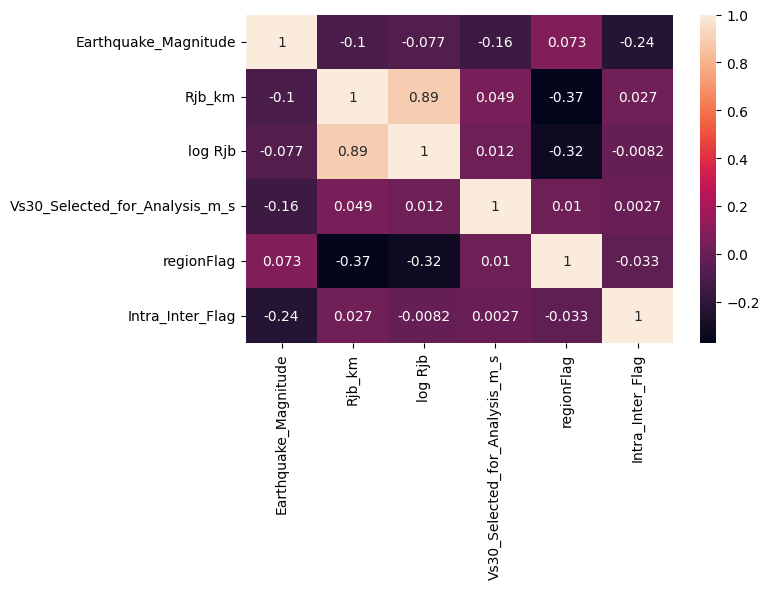

In [241]:
import seaborn as sns
plt.figure(figsize=(8,6))

sns.heatmap(df[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag','Intra_Inter_Flag']].corr(), annot = True)
# sns.heatmap(df[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag']].corr(), annot = True)

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/input covariance.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

In [ ]:
n_samples, n_feature = X.shape
n_s, n_labels = y.shape

print(n_samples, n_feature)
print(n_s, n_labels)

batch_size = 32


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=51)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state=51)

X_train = torch.tensor(X_train.astype(np.float32).values)
X_test = torch.tensor(X_test.astype(np.float32).values)
y_train = torch.tensor(y_train.astype(np.float32).values)
y_test = torch.tensor(y_test.astype(np.float32).values)
X_val = torch.tensor(X_val.astype(np.float32).values)
y_val = torch.tensor(y_val.astype(np.float32).values)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

15184 6
15184 113


**ANN Model**

In [ ]:
class ANN(nn.Module):
  def __init__(self,n_input_featurs, hidden_layer, n_output_labels):
    super(ANN, self).__init__()
    self.linear1 = nn.Linear(n_input_featurs, hidden_layer)
    self.linear2 = nn.Linear(hidden_layer, hidden_layer)
    self.linear3 = nn.Linear(hidden_layer, n_output_labels)

  def forward(self, x):
    x = F.leaky_relu(self.linear1(x), negative_slope=0.01)
    x = F.leaky_relu(self.linear2(x), negative_slope=0.01)
    x = self.linear3(x)

    return x

 **CVAE Model**

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super(Encoder, self).__init__()
    self.l1 = nn.Linear(input_dim, 64)
    self.l11 = nn.Linear(64, 64)
    # dividing the data into probabilistic distribution
    self.l2_mean = nn.Linear(64, latent_dim)
    self.l2_logvar = nn.Linear(64, latent_dim)

  def forward(self, x):
    x = F.leaky_relu(self.l1(x), negative_slope=0.1)
    x = F.leaky_relu(self.l11(x), negative_slope=0.1)
    mean = self.l2_mean(x)
    logvar = self.l2_logvar(x)

    return mean, logvar


In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim):
    super(Decoder, self).__init__()
    self.l1 = nn.Linear(latent_dim, 64)
    self.l11 = nn.Linear(64, 64)
    self.l2 = nn.Linear(64, output_dim)

  def forward(self, x):
    x = F.leaky_relu(self.l1(x), negative_slope=0.1)
    x = F.leaky_relu(self.l11(x), negative_slope=0.1)
    x_recon = self.l2(x)

    return x_recon


In [ ]:
class VAE(nn.Module):
  def __init__(self, input_dim, latent_dim, output_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(input_dim, latent_dim)
    self.decoder = Decoder(latent_dim, output_dim)

  def forward(self, x):
    mean, logvar = self.encoder(x)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)   # this takes out a random numbers to create a tensor with mean = 0 and std dev = 1 with same shape as std
    z = mean + eps * std
    x_recon = self.decoder(z)    # this is the reconstrucrted Response Spectra (RS)

    return x_recon, mean, logvar

In [ ]:
def VAE_loss(x_recon, x, mean, logvar):
  recon_loss = F.mse_loss(x_recon, x, reduction='sum')   # MSE loss between reconstructed RS and actual RS
  kl_d = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())   # this is the KL Divergence Loss function
  return recon_loss + kl_d   # total Loss

-------------------------------------------------------------------------------------------------------------------------------------------------------

**ANN Training**

In [ ]:
input_dim_ANN =  n_feature  # 6 parameters on which the RS is to be predicted
output_dim = n_labels  # output contains log PSA for 111 time stamps + PGA + PGV

model_ANN = ANN(input_dim_ANN, 64, output_dim)


learning_rate1 = 0.001
criterion = nn.MSELoss()
optimizer1 = optim.AdamW(model_ANN.parameters(), lr = learning_rate1)

In [ ]:
n_epochs = 120
best_loss = float('inf')

for epoch in range(n_epochs):
  model_ANN.train()
  ep_loss = 0.0
  valid_loss = 0.0
  for i, data in enumerate(train_loader):
    input, output = data


    y_pred = model_ANN(input)
    loss = criterion(y_pred, output)

    loss.backward()

    optimizer1.step()
    optimizer1.zero_grad()

    ep_loss += loss.item()

  with torch.no_grad():
    model_ANN.eval()

    for i, data in enumerate(val_loader):
      input, output = data


      val_y_pred = model_ANN(input)
      val_loss = criterion(val_y_pred, output)
      valid_loss += val_loss.item()



  print(f'Epoch {epoch+1} / {n_epochs} completed. Average Loss: {ep_loss / len(train_loader):.4f}, Average Validation Loss: {valid_loss / len(val_loader):.4f}')

  if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model_ANN.state_dict(), '/content/drive/MyDrive/SEISMIC MODELS/VAE/best_ANN_model_Subduction.pth')
        print(f'Best Model Saved at {epoch+1}')

Epoch 1 / 120 completed. Average Loss: 5.2315, Average Validation Loss: 0.6664
Best Model Saved at 1
Epoch 2 / 120 completed. Average Loss: 0.6796, Average Validation Loss: 0.6078
Best Model Saved at 2
Epoch 3 / 120 completed. Average Loss: 0.6121, Average Validation Loss: 0.6007
Best Model Saved at 3
Epoch 4 / 120 completed. Average Loss: 0.5654, Average Validation Loss: 0.5127
Best Model Saved at 4
Epoch 5 / 120 completed. Average Loss: 0.5196, Average Validation Loss: 0.4876
Best Model Saved at 5
Epoch 6 / 120 completed. Average Loss: 0.5024, Average Validation Loss: 0.4814
Best Model Saved at 6
Epoch 7 / 120 completed. Average Loss: 0.4983, Average Validation Loss: 0.4691
Best Model Saved at 7
Epoch 8 / 120 completed. Average Loss: 0.4820, Average Validation Loss: 0.4384
Best Model Saved at 8
Epoch 9 / 120 completed. Average Loss: 0.4696, Average Validation Loss: 0.4272
Best Model Saved at 9
Epoch 10 / 120 completed. Average Loss: 0.4588, Average Validation Loss: 0.4211
Best Model 

In [ ]:
path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/best_ANN_model_Subduction.pth'
state_dict = torch.load(path)


# model_ANN = ANN(input_dim_ANN, 10, output_dim)


model_ANN.load_state_dict(state_dict)


model_ANN.eval()
with torch.no_grad():
    y_pred = model_ANN(X_test)

<ipython-input-69-5249312b39bc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


In [ ]:
y_p = y_pred.detach().numpy()
y_t = y_test.detach().numpy()

In [ ]:
from sklearn.metrics import r2_score

# Calculate R^2 score for the first dataframe

for i in range(111):
  r2_score_1 = r2_score(y_p[:,i], y_t[:,i])
  print(f"r2 score for col {i+1}:", r2_score_1)


r2 score for col 1: 0.8043979616574023
r2 score for col 2: 0.803457378754739
r2 score for col 3: 0.8022120628347009
r2 score for col 4: 0.8008570092778695
r2 score for col 5: 0.7997552542052344
r2 score for col 6: 0.7996663993639626
r2 score for col 7: 0.7986871569195153
r2 score for col 8: 0.7965490362359556
r2 score for col 9: 0.795883704079815
r2 score for col 10: 0.7934804117335101
r2 score for col 11: 0.7920607049212183
r2 score for col 12: 0.7906572783251178
r2 score for col 13: 0.7907189969524238
r2 score for col 14: 0.7892264818008133
r2 score for col 15: 0.7873104658220422
r2 score for col 16: 0.7863952665275701
r2 score for col 17: 0.7809336403589386
r2 score for col 18: 0.7753163886217458
r2 score for col 19: 0.7696643195979593
r2 score for col 20: 0.7689270197826765
r2 score for col 21: 0.7658064485339324
r2 score for col 22: 0.7620939766790009
r2 score for col 23: 0.7589135340044563
r2 score for col 24: 0.7551435967417611
r2 score for col 25: 0.7496299488715722
r2 score fo

In [ ]:
r2_score_1 = r2_score(y_p[:,:], y_t[:,:])
print(f"r2 score for ANN:", r2_score_1)

r2 score for ANN: 0.7972773451606722


===================================================================================================================

In [ ]:
input_dim = n_labels
latent_dim = 3
output_dim = n_labels
learning_rate = 0.001
epochs = 100

model = VAE(input_dim, latent_dim, output_dim)
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

In [ ]:
best_loss = float('inf')

for epoch in range(epochs):
  model.train()
  ep_loss = 0.0
  valid_loss = 0.0
  for i, data in enumerate(train_loader):
    _, output = data
    optimizer.zero_grad()

    x_recon, mean, logvar = model(output)
    loss = VAE_loss(x_recon, output, mean, logvar)

    loss.backward()

    optimizer.step()


    ep_loss += loss.item()


  model.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      _, output = data

      x_recon, mean, logvar = model(output)
      val_loss = VAE_loss(x_recon, output, mean, logvar)
      valid_loss += val_loss.item()



  print(f'Epoch {epoch+1} / {epochs} completed. Average Loss: {ep_loss / len(train_loader):.4f}, Average Validation Loss: {valid_loss / len(val_loader):.4f}')

  if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/SEISMIC MODELS/VAE/best_VAE_model_Subduction.pth')
        print(f'Best Model Saved at {epoch+1}')

Epoch 1 / 100 completed. Average Loss: 2036.4408, Average Validation Loss: 446.5197
Best Model Saved at 1
Epoch 2 / 100 completed. Average Loss: 335.1942, Average Validation Loss: 335.2710
Best Model Saved at 2
Epoch 3 / 100 completed. Average Loss: 285.6326, Average Validation Loss: 274.4173
Best Model Saved at 3
Epoch 4 / 100 completed. Average Loss: 267.6108, Average Validation Loss: 274.2925
Best Model Saved at 4
Epoch 5 / 100 completed. Average Loss: 266.5737, Average Validation Loss: 273.1360
Best Model Saved at 5
Epoch 6 / 100 completed. Average Loss: 257.1253, Average Validation Loss: 249.5250
Best Model Saved at 6
Epoch 7 / 100 completed. Average Loss: 257.3814, Average Validation Loss: 354.6310
Epoch 8 / 100 completed. Average Loss: 256.6510, Average Validation Loss: 254.0870
Epoch 9 / 100 completed. Average Loss: 251.9728, Average Validation Loss: 262.6169
Epoch 10 / 100 completed. Average Loss: 251.1957, Average Validation Loss: 256.9668
Epoch 11 / 100 completed. Average Lo

In [ ]:
path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/best_VAE_model_Subduction.pth'
state_dict = torch.load(path)


# model = VAE(input_dim, latent_dim, output_dim)


model.load_state_dict(state_dict)

<ipython-input-82-0b98d2622f58>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


<All keys matched successfully>

In [ ]:
model.eval()

with torch.no_grad():
  y_t = model_ANN(torch.tensor(X_test.float()))
  y_npa,_,_ = model(torch.tensor(y_t).float())

y_p_vae = y_npa.detach().numpy()

<ipython-input-83-b7e9c05e8266>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = model_ANN(torch.tensor(X_test.float()))
<ipython-input-83-b7e9c05e8266>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_npa,_,_ = model(torch.tensor(y_t).float())


In [ ]:
y_p_vae.shape

(2278, 113)

In [ ]:
from sklearn.metrics import r2_score

# Calculate R^2 score for the first dataframe
r = 0

for i in range(111):
  r2_score_1 = r2_score(y_p_vae[:,i], y_test[:,i])
  print(f"r2 score for col {i+1}:", r2_score_1)

r2 score for col 1: 0.8084729073812539
r2 score for col 2: 0.8073233628123221
r2 score for col 3: 0.8067620867613547
r2 score for col 4: 0.806207527268708
r2 score for col 5: 0.8046883838661922
r2 score for col 6: 0.8040050773890837
r2 score for col 7: 0.8030069921410017
r2 score for col 8: 0.8015680238472207
r2 score for col 9: 0.8008653668850856
r2 score for col 10: 0.7982155383410799
r2 score for col 11: 0.7965179924804522
r2 score for col 12: 0.7946789038366632
r2 score for col 13: 0.7942122980835835
r2 score for col 14: 0.793574666383602
r2 score for col 15: 0.7910013874490102
r2 score for col 16: 0.7893082155460879
r2 score for col 17: 0.7835310098115505
r2 score for col 18: 0.7773461019221504
r2 score for col 19: 0.7712083927339035
r2 score for col 20: 0.7702818325495209
r2 score for col 21: 0.7680501027930844
r2 score for col 22: 0.7639340165671831
r2 score for col 23: 0.7600205796384165
r2 score for col 24: 0.7558793183790435
r2 score for col 25: 0.7517951925426356
r2 score fo

In [ ]:
r2_score_1 = r2_score(y_p_vae[:,:], y_test[:,:])
print(f"r2 score for VAE:", r2_score_1)

r2 score for VAE: 0.7821379427807511


In [ ]:
bins = [4, 5, 6, 7, 8, 9]
labels = ['4-5', '5-6', '6-7', '7-8', '8-9']
df['Magnitude_Range'] = pd.cut(df['Earthquake_Magnitude'], bins=bins, labels=labels, right=False)
count_per_range = df['Magnitude_Range'].value_counts()
print(count_per_range)

Magnitude_Range
6-7    8119
7-8    2843
5-6    1989
8-9     783
4-5     182
Name: count, dtype: int64


**PLOTS**

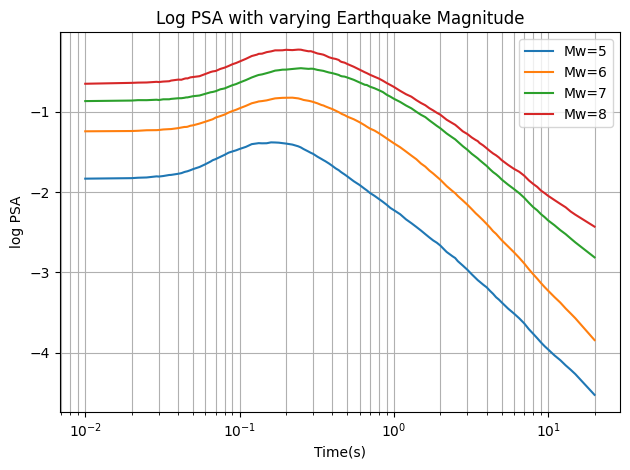

In [245]:
l=[]

model_ANN.eval()
model.eval()

rjb = 25
region = 1
intra_inter = 1

r = [5,rjb,np.log10(rjb),600,region,intra_inter]
r1 = [6,rjb,np.log10(rjb), 600,region,intra_inter]
r2 = [7,rjb,np.log10(rjb), 600,region,intra_inter]
r3 = [8,rjb,np.log10(rjb), 600,region,intra_inter]


l.append(r)
l.append(r1)
l.append(r2)
l.append(r3)


l = torch.tensor(l, dtype=torch.float32)


with torch.no_grad():
  rp = model_ANN(l)
  prs,_,_ = model(rp)

plt.plot(t, prs[0][:-2], label='Mw=5')
plt.plot(t, prs[1][:-2], label='Mw=6')
plt.plot(t, prs[2][:-2], label='Mw=7')
plt.plot(t, prs[3][:-2], label='Mw=8')

plt.xlabel('Time(s)')
plt.ylabel('log PSA')
plt.xscale('log')
plt.grid(True, which = 'both')
plt.title('Log PSA with varying Earthquake Magnitude')

plt.legend()

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/log PSA with varying Earthquake Magnitude.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

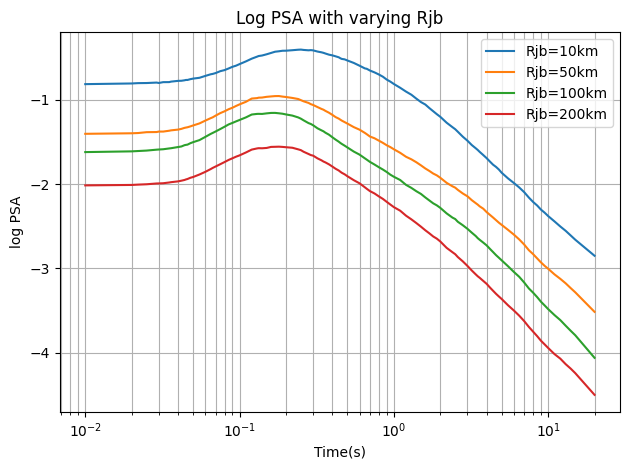

In [251]:
l=[]

model_ANN.eval()
model.eval()

rjb = [10,50,100,200]
region = 1
intra_inter = 1

r = [6.5,rjb[0],np.log10(rjb[0]),600,region,intra_inter]
r1 = [6.5,rjb[1],np.log10(rjb[1]), 600,region,intra_inter]
r2 = [6.5,rjb[2],np.log10(rjb[2]), 600,region,intra_inter]
r3 = [6.5,rjb[3],np.log10(rjb[3]), 600,region,intra_inter]


l.append(r)
l.append(r1)
l.append(r2)
l.append(r3)


l = torch.tensor(l, dtype=torch.float32)


with torch.no_grad():
  rp = model_ANN(l)
  prs,_,_ = model(rp)

plt.plot(t, prs[0][:-2], label=f'Rjb={rjb[0]}km')
plt.plot(t, prs[1][:-2], label=f'Rjb={rjb[1]}km')
plt.plot(t, prs[2][:-2], label=f'Rjb={rjb[2]}km')
plt.plot(t, prs[3][:-2], label=f'Rjb={rjb[3]}km')

plt.xlabel('Time(s)')
plt.ylabel('log PSA')
plt.xscale('log')
plt.grid(True, which = 'both')
plt.title('Log PSA with varying Rjb')

plt.legend()

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/log PSA with varying Rjb.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

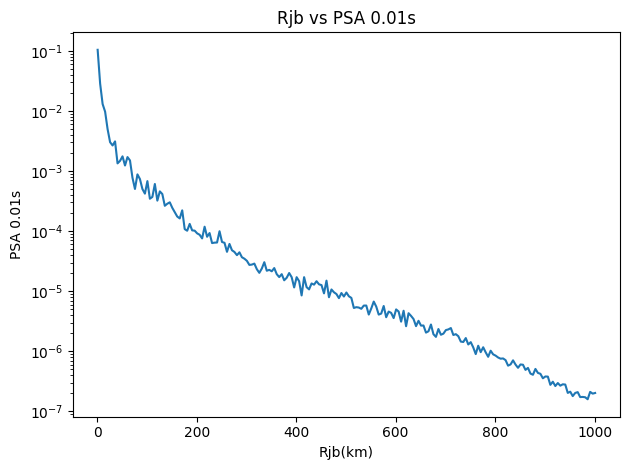

In [252]:
l = []

rjb = np.arange(1,1005,5)
region = 1
intra_inter = 1


for d in rjb:
  r = [4,d,np.log10(d),600,region,intra_inter]
  l.append(r)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)
  prs,_,_ = model(rs)

plt.plot(l[:, 1], 10**prs[:, 0])
plt.xlabel('Rjb(km)')
plt.ylabel('PSA 0.01s')
plt.yscale('log')
plt.title('Rjb vs PSA 0.01s')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Rjb vs PSA 0.01s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

In [ ]:
df.head()

,NGAsubRSN,DatabaseRegion,NGAsubEQID,NGAsubSSN,Earthquake_Name,YEAR,MODY,HRMN,Earthquake_Magnitude,Hypocenter_Latitude_deg,...,log PSA 8.5,log PSA 9.0,log PSA 9.5,log PSA 10.0,log PSA 11.0,log PSA 12.0,log PSA 13.0,log PSA 14.0,log PSA 15.0,log PSA 20.0
0,1000002,Alaska,1000001,1000002,Aleutian_Isl-Alaska,2014,623,2053,7.96,51.6928,...,-3.216558,-3.264171,-3.302656,-3.338933,-3.380525,-3.411780,-3.439308,-3.470705,-3.510628,-3.740679
1,1000008,Alaska,1000001,1000008,Aleutian_Isl-Alaska,2014,623,2053,7.96,51.6928,...,-3.746548,-3.795255,-3.834041,-3.873305,-3.929919,-3.981767,-4.032910,-4.077853,-4.130885,-4.407429
2,1000040,Alaska,1000003,1000008,3316471,2011,624,309,7.28,51.9805,...,-3.234213,-3.284862,-3.326140,-3.368563,-3.438885,-3.501920,-3.563095,-3.618772,-3.676877,-3.951620
3,1000056,Alaska,1000004,1000008,2587660,2007,1219,930,7.21,51.3510,...,-3.860660,-3.909341,-3.946646,-3.983694,-4.028896,-4.070506,-4.108992,-4.146345,-4.194757,-4.465693
4,1000069,Alaska,1000005,1000005,4224881,2013,830,1625,7.00,51.6230,...,-4.262531,-4.313018,-4.351326,-4.390359,-4.438762,-4.485588,-4.529632,-4.569188,-4.620214,-4.907287


In [ ]:
intra = df[df['Intra_Inter_Flag'] == 1]
intra.reset_index(drop=True, inplace=True)

inter = df[df['Intra_Inter_Flag'] == 0]
inter.reset_index(drop=True, inplace=True)

In [ ]:
print(inter.shape)
print(intra.shape)

(8519, 230)
(6147, 230)


**INTER RESIDDUE**

In [ ]:
def categorize_magnitudes(inter, lower_bound=4, upper_bound=9, bin_size=0.5):
    bins = list(pd.interval_range(start=lower_bound, end=upper_bound, freq=bin_size).left)
    bins.append(upper_bound)
    labels = [f"{round(bins[i], 1)}-{round(bins[i + 1], 1)}" for i in range(len(bins) - 1)]
    if not isinstance(inter, pd.DataFrame):
        inter = pd.DataFrame(inter, columns=['Earthquake_Magnitude'])
    inter['mag_range'] = pd.cut(inter['Earthquake_Magnitude'], bins=bins, labels=labels, right=False)

    return inter

categorize_magnitudes(inter)


<ipython-input-175-a9b7f3ded7e2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter['mag_range'] = pd.cut(inter['Earthquake_Magnitude'], bins=bins, labels=labels, right=False)


,NGAsubRSN,DatabaseRegion,NGAsubEQID,NGAsubSSN,Earthquake_Name,YEAR,MODY,HRMN,Earthquake_Magnitude,Hypocenter_Latitude_deg,...,T11pt000S,T12pt000S,T13pt000S,T14pt000S,T15pt000S,T20pt000S,log Rjb,regionFlag,Magnitude_Range,mag_range
0,1000056,Alaska,1000004,1000008,2587660,2007,1219,930,7.21,51.351000,...,0.000124,0.000125,0.000148,0.000138,0.000164,0.000172,2.858969,1,7-8,7.0-7.5
1,1000069,Alaska,1000005,1000005,4224881,2013,830,1625,7.00,51.623000,...,0.000030,0.000037,0.000039,0.000045,0.000049,0.000041,2.925235,1,7-8,7.0-7.5
2,1000074,Alaska,1000005,1000008,4224881,2013,830,1625,7.00,51.623000,...,0.000089,0.000095,0.000102,0.000103,0.000091,0.000056,2.643576,1,7-8,7.0-7.5
3,1000175,Alaska,1000012,1000002,1495286,2003,219,332,6.64,53.615000,...,0.000028,0.000029,0.000026,0.000029,0.000029,0.000026,2.802839,1,6-7,6.5-7.0
4,1000182,Alaska,1000012,1000012,1495286,2003,219,332,6.64,53.615000,...,0.000040,0.000036,0.000032,0.000038,0.000042,0.000022,2.427573,1,6-7,6.5-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8514,7012036,Taiwan,7000074,7000819,603160286,2013,628,2351,5.69,24.026833,...,0.000008,0.000007,0.000006,0.000006,0.000006,0.000004,2.429368,6,5-6,5.5-6.0
8515,7012037,Taiwan,7000074,7000828,603160286,2013,628,2351,5.69,24.026833,...,0.000045,0.000038,0.000033,0.000031,0.000026,0.000011,2.090306,6,5-6,5.5-6.0
8516,7012038,Taiwan,7000074,7000839,603160286,2013,628,2351,5.69,24.026833,...,0.000029,0.000023,0.000020,0.000020,0.000017,0.000010,2.032188,6,5-6,5.5-6.0
8517,7012039,Taiwan,7000074,7000834,603160286,2013,628,2351,5.69,24.026833,...,0.000039,0.000034,0.000029,0.000023,0.000019,0.000008,2.034763,6,5-6,5.5-6.0


In [ ]:
inter

,NGAsubRSN,DatabaseRegion,NGAsubEQID,NGAsubSSN,Earthquake_Name,YEAR,MODY,HRMN,Earthquake_Magnitude,Hypocenter_Latitude_deg,...,T11pt000S,T12pt000S,T13pt000S,T14pt000S,T15pt000S,T20pt000S,log Rjb,regionFlag,Magnitude_Range,mag_range
0,1000056,Alaska,1000004,1000008,2587660,2007,1219,930,7.21,51.351000,...,0.000124,0.000125,0.000148,0.000138,0.000164,0.000172,2.858969,1,7-8,7.0-7.5
1,1000069,Alaska,1000005,1000005,4224881,2013,830,1625,7.00,51.623000,...,0.000030,0.000037,0.000039,0.000045,0.000049,0.000041,2.925235,1,7-8,7.0-7.5
2,1000074,Alaska,1000005,1000008,4224881,2013,830,1625,7.00,51.623000,...,0.000089,0.000095,0.000102,0.000103,0.000091,0.000056,2.643576,1,7-8,7.0-7.5
3,1000175,Alaska,1000012,1000002,1495286,2003,219,332,6.64,53.615000,...,0.000028,0.000029,0.000026,0.000029,0.000029,0.000026,2.802839,1,6-7,6.5-7.0
4,1000182,Alaska,1000012,1000012,1495286,2003,219,332,6.64,53.615000,...,0.000040,0.000036,0.000032,0.000038,0.000042,0.000022,2.427573,1,6-7,6.5-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8514,7012036,Taiwan,7000074,7000819,603160286,2013,628,2351,5.69,24.026833,...,0.000008,0.000007,0.000006,0.000006,0.000006,0.000004,2.429368,6,5-6,5.5-6.0
8515,7012037,Taiwan,7000074,7000828,603160286,2013,628,2351,5.69,24.026833,...,0.000045,0.000038,0.000033,0.000031,0.000026,0.000011,2.090306,6,5-6,5.5-6.0
8516,7012038,Taiwan,7000074,7000839,603160286,2013,628,2351,5.69,24.026833,...,0.000029,0.000023,0.000020,0.000020,0.000017,0.000010,2.032188,6,5-6,5.5-6.0
8517,7012039,Taiwan,7000074,7000834,603160286,2013,628,2351,5.69,24.026833,...,0.000039,0.000034,0.000029,0.000023,0.000019,0.000008,2.034763,6,5-6,5.5-6.0


In [ ]:
import re

inter_X = inter[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag','Intra_Inter_Flag']]


pattern = re.compile(r'^T(\d+)pt(\d{3})S$')

matching_columns = []
t = []

for col in inter.columns:
    match = pattern.match(col)
    if match:

        minutes = int(match.group(1))
        seconds = int(match.group(2)) / 1000.0

        total_seconds = minutes + seconds


        if 0.01 <= total_seconds <= 20.000:
            matching_columns.append(col)
            t.append(total_seconds)
inter_y = inter[matching_columns]

inter_y['PGA'] = inter['PGA_g']
inter_y['PGV'] = inter['PGV_cm_sec']

inter_y = np.log10(inter_y.replace(0, np.nan) + 1e-10)

<ipython-input-177-5e601b708516>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter_y['PGA'] = inter['PGA_g']
<ipython-input-177-5e601b708516>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter_y['PGV'] = inter['PGV_cm_sec']


In [ ]:
inter_X = torch.tensor(inter_X.values).float()
inter_y = torch.tensor(inter_y.values).float()

In [ ]:
with torch.no_grad():
  inter_y_pred = model_ANN(inter_X)
  inter_y_pred,_,_ = model(inter_y_pred)

In [ ]:
residuals_inter = 10**inter_y.float() - 10**inter_y_pred.float()

In [ ]:
tc = []

for time in t:
  tc.append('T'+str(time))

tc.append('PGA')
tc.append('PGV')


In [ ]:
residuals_inter = residuals_inter.detach().numpy()

new_inter = pd.DataFrame(residuals_inter)
new_inter.columns = tc

In [ ]:
new_inter = pd.concat([new_inter, inter['mag_range'], inter['Earthquake_Magnitude']], axis = 1)

In [230]:
new_inter

,T0.01,T0.02,T0.022,T0.025,T0.029,T0.03,T0.032,T0.035,T0.036,T0.04,...,T11.0,T12.0,T13.0,T14.0,T15.0,T20.0,PGA,PGV,mag_range,Earthquake_Magnitude
0,0.000613,0.000613,0.000612,0.000609,0.000609,0.000609,0.000608,0.000604,0.000606,0.000608,...,0.000073,0.000077,0.000103,0.000096,0.000125,0.000147,0.000613,0.101887,7.0-7.5,7.21
1,0.000382,0.000382,0.000382,0.000381,0.000382,0.000381,0.000382,0.000382,0.000382,0.000383,...,0.000011,0.000019,0.000023,0.000029,0.000034,0.000032,0.000381,0.050392,7.0-7.5,7.00
2,0.000699,0.000689,0.000686,0.000684,0.000669,0.000673,0.000668,0.000661,0.000667,0.000652,...,-0.000085,-0.000069,-0.000053,-0.000044,-0.000048,-0.000032,0.000704,-0.072761,7.0-7.5,7.00
3,-0.000121,-0.000122,-0.000122,-0.000123,-0.000123,-0.000125,-0.000125,-0.000126,-0.000126,-0.000125,...,0.000008,0.000010,0.000009,0.000013,0.000015,0.000017,-0.000122,-0.015848,6.5-7.0,6.64
4,-0.001055,-0.001061,-0.001065,-0.001066,-0.001072,-0.001073,-0.001086,-0.001092,-0.001096,-0.001098,...,-0.000055,-0.000051,-0.000046,-0.000034,-0.000024,-0.000017,-0.001050,-0.190739,6.5-7.0,6.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8514,-0.000580,-0.000582,-0.000588,-0.000590,-0.000599,-0.000598,-0.000595,-0.000600,-0.000608,-0.000613,...,-0.000016,-0.000015,-0.000013,-0.000011,-0.000009,-0.000005,-0.000579,-0.059049,5.5-6.0,5.69
8515,0.002696,0.002672,0.002659,0.002628,0.002611,0.002604,0.002597,0.002553,0.002532,0.002501,...,0.000019,0.000015,0.000013,0.000012,0.000009,0.000002,0.002710,0.405524,5.5-6.0,5.69
8516,-0.001851,-0.001878,-0.001912,-0.001927,-0.001983,-0.001991,-0.001999,-0.002050,-0.002104,-0.002157,...,-0.000031,-0.000031,-0.000027,-0.000023,-0.000020,-0.000011,-0.001805,-0.069359,5.5-6.0,5.69
8517,-0.001555,-0.001572,-0.001601,-0.001608,-0.001650,-0.001654,-0.001652,-0.001686,-0.001723,-0.001764,...,-0.000013,-0.000013,-0.000011,-0.000013,-0.000013,-0.000010,-0.001522,-0.047348,5.5-6.0,5.69


<Figure size 800x600 with 0 Axes>

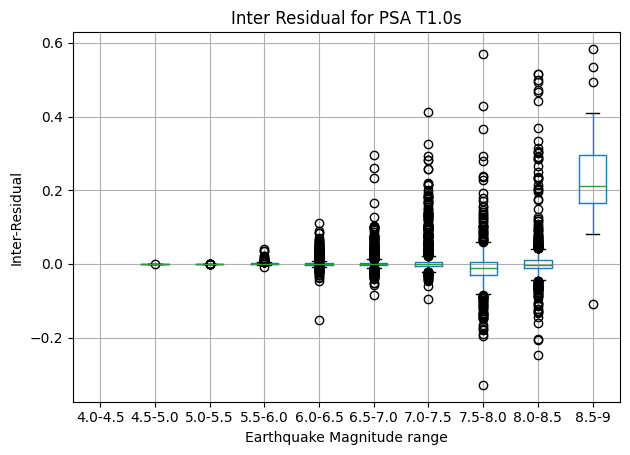

In [253]:
plt.figure(figsize=(8, 6))
new_inter.boxplot(column='T1.0', by='mag_range')


plt.title('Inter Residual for PSA T1.0s')
plt.suptitle('')
plt.xlabel('Earthquake Magnitude range')
plt.ylabel('Inter-Residual')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Inter Residual for PSA T1.0s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

<Figure size 800x600 with 0 Axes>

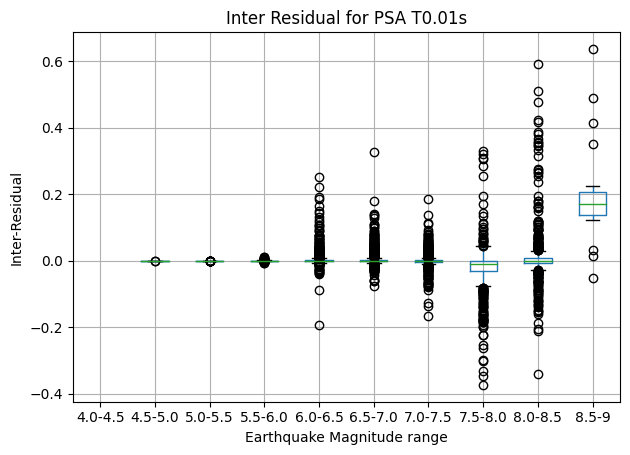

In [254]:
plt.figure(figsize=(8, 6))
new_inter.boxplot(column='T0.01', by='mag_range')


plt.title('Inter Residual for PSA T0.01s')
plt.suptitle('')
plt.xlabel('Earthquake Magnitude range')
plt.ylabel('Inter-Residual')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Inter Residual for PSA T0.01s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

<Figure size 800x600 with 0 Axes>

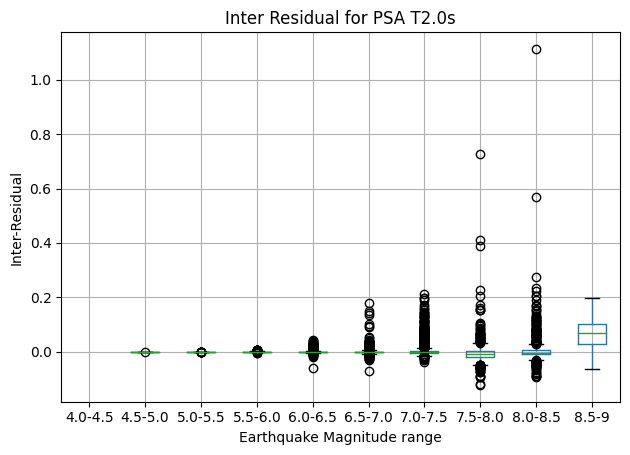

In [255]:
plt.figure(figsize=(8, 6))
new_inter.boxplot(column='T2.0', by='mag_range')


plt.title('Inter Residual for PSA T2.0s')
plt.suptitle('')
plt.xlabel('Earthquake Magnitude range')
plt.ylabel('Inter-Residual')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Inter Residual for PSA T2.0s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

<Figure size 800x600 with 0 Axes>

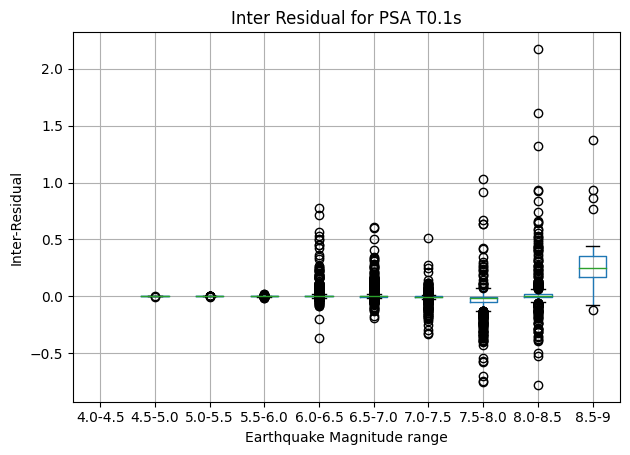

In [257]:
plt.figure(figsize=(8, 6))
new_inter.boxplot(column='T0.1', by='mag_range')


plt.title('Inter Residual for PSA T0.1s')
plt.suptitle('')
plt.xlabel('Earthquake Magnitude range')
plt.ylabel('Inter-Residual')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Inter Residual for PSA T0.1s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

<Figure size 800x600 with 0 Axes>

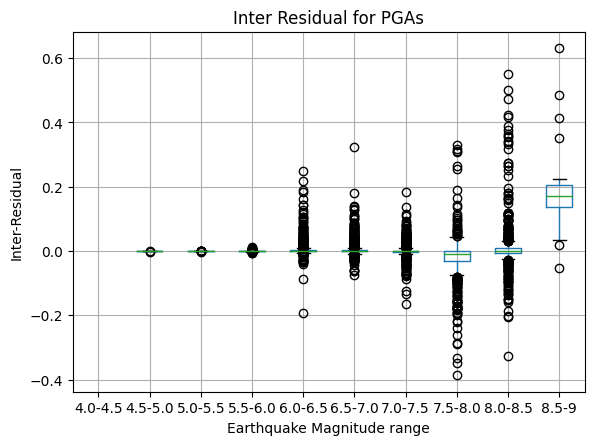

In [ ]:
plt.figure(figsize=(8, 6))
new_inter.boxplot(column='PGA', by='mag_range')


plt.title('Inter Residual for PGAs')
plt.suptitle('')
plt.xlabel('Earthquake Magnitude range')
plt.ylabel('Inter-Residual')

plt.show()

<Figure size 800x600 with 0 Axes>

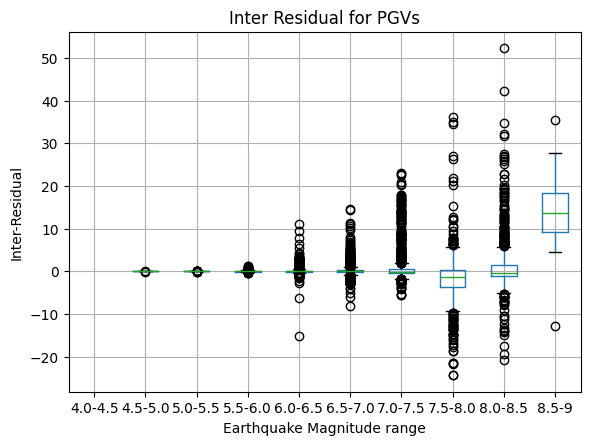

In [ ]:
plt.figure(figsize=(8, 6))
new_inter.boxplot(column='PGV', by='mag_range')


plt.title('Inter Residual for PGVs')
plt.suptitle('')
plt.xlabel('Earthquake Magnitude range')
plt.ylabel('Inter-Residual')

plt.show()

**INTRA RESIDUE**

In [ ]:
def categorize_magnitudes(intra, lower_bound=0, upper_bound=1000, bin_size=100):
    bins = list(pd.interval_range(start=lower_bound, end=upper_bound, freq=bin_size).left)
    bins.append(upper_bound)
    labels = [f"{round(bins[i], 1)}-{round(bins[i + 1], 1)}" for i in range(len(bins) - 1)]
    if not isinstance(intra, pd.DataFrame):
        intra = pd.DataFrame(intra, columns=['Rjb_km'])
    intra['Rjb_range'] = pd.cut(intra['Rjb_km'], bins=bins, labels=labels, right=False)

    return intra

categorize_magnitudes(intra)

<ipython-input-215-cab57b73e70c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intra['Rjb_range'] = pd.cut(intra['Rjb_km'], bins=bins, labels=labels, right=False)


,NGAsubRSN,DatabaseRegion,NGAsubEQID,NGAsubSSN,Earthquake_Name,YEAR,MODY,HRMN,Earthquake_Magnitude,Hypocenter_Latitude_deg,...,T11pt000S,T12pt000S,T13pt000S,T14pt000S,T15pt000S,T20pt000S,log Rjb,regionFlag,Magnitude_Range,Rjb_range
0,1000002,Alaska,1000001,1000002,Aleutian_Isl-Alaska,2014,623,2053,7.96,51.692800,...,3.357962e-04,3.323678e-04,2.628345e-04,2.154366e-04,1.867033e-04,1.188908e-04,2.609872,1,7-8,400-500
1,1000008,Alaska,1000001,1000008,Aleutian_Isl-Alaska,2014,623,2053,7.96,51.692800,...,1.872273e-04,1.993685e-04,2.181306e-04,2.365434e-04,2.156239e-04,8.402836e-05,2.888727,1,7-8,700-800
2,1000040,Alaska,1000003,1000008,3316471,2011,624,309,7.28,51.980500,...,4.603406e-04,3.545166e-04,2.858433e-04,2.234650e-04,1.584509e-04,6.979291e-05,2.293457,1,7-8,100-200
3,1000086,Alaska,1000006,1000002,3321405,2011,902,1055,6.89,52.101800,...,1.990250e-04,1.802421e-04,2.046143e-04,2.187548e-04,2.219064e-04,1.263770e-04,2.172591,1,6-7,100-200
4,1000125,Alaska,1000007,1000033,1211824,2001,728,732,6.65,59.014000,...,5.938282e-06,4.555558e-06,3.255038e-06,3.070240e-06,2.406843e-06,1.164557e-06,2.786759,1,6-7,600-700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6142,7011987,Taiwan,7000072,7000829,601111906,2012,609,2100,5.91,24.456667,...,2.597186e-05,2.115041e-05,1.613225e-05,1.227426e-05,9.976004e-06,4.802517e-06,2.184747,6,5-6,100-200
6143,7012008,Taiwan,7000073,7000836,602601483,2013,312,903,4.20,24.356333,...,1.565145e-06,1.306098e-06,1.103870e-06,9.440335e-07,8.158965e-07,4.444551e-07,1.616220,6,4-5,0-100
6144,7012012,Taiwan,7000073,7000824,602601483,2013,312,903,4.20,24.356333,...,6.790868e-07,5.504711e-07,4.621087e-07,4.012339e-07,3.528538e-07,1.993947e-07,2.021406,6,4-5,100-200
6145,7012013,Taiwan,7000073,7000818,602601483,2013,312,903,4.20,24.356333,...,8.198871e-07,6.883234e-07,5.850256e-07,4.988426e-07,4.279507e-07,2.332140e-07,1.807842,6,4-5,0-100


In [ ]:
import re

intra_X = intra[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag','Intra_Inter_Flag']]


pattern = re.compile(r'^T(\d+)pt(\d{3})S$')

matching_columns = []
t = []

for col in inter.columns:
    match = pattern.match(col)
    if match:

        minutes = int(match.group(1))
        seconds = int(match.group(2)) / 1000.0

        total_seconds = minutes + seconds


        if 0.01 <= total_seconds <= 20.000:
            matching_columns.append(col)
            t.append(total_seconds)
intra_y = intra[matching_columns]

intra_y['PGA'] = intra['PGA_g']
intra_y['PGV'] = intra['PGV_cm_sec']

intra_y = np.log10(intra_y.replace(0, np.nan) + 1e-10)

<ipython-input-216-fd87893bdcc7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intra_y['PGA'] = intra['PGA_g']
<ipython-input-216-fd87893bdcc7>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intra_y['PGV'] = intra['PGV_cm_sec']


In [ ]:
intra_X = torch.tensor(intra_X.values).float()
intra_y = torch.tensor(intra_y.values).float()

In [ ]:
with torch.no_grad():
  intra_y_pred = model_ANN(intra_X)
  intra_y_pred,_,_ = model(intra_y_pred)

In [ ]:
residuals_intra = 10**intra_y.float() - 10**intra_y_pred.float()

new_intra = pd.DataFrame(residuals_intra)
new_intra.columns = tc

In [ ]:
new_intra = pd.concat([new_intra, intra['Rjb_range'], intra['Rjb_km']], axis = 1)

<Figure size 800x600 with 0 Axes>

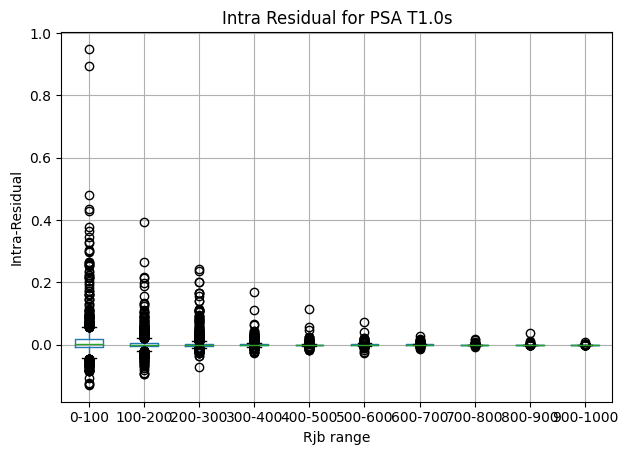

In [258]:
plt.figure(figsize=(8, 6))
new_intra.boxplot(column='T1.0', by='Rjb_range')


plt.title('Intra Residual for PSA T1.0s')
plt.suptitle('')
plt.xlabel('Rjb range')
plt.ylabel('Intra-Residual')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Intra Residual for PSA T1.0s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

<Figure size 800x600 with 0 Axes>

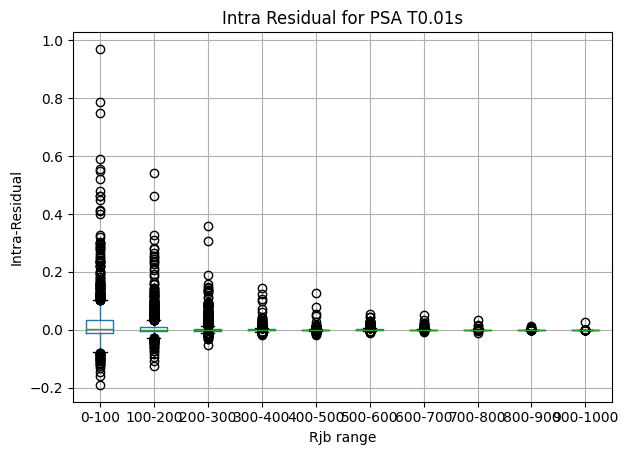

In [259]:
plt.figure(figsize=(8, 6))
new_intra.boxplot(column='T0.01', by='Rjb_range')


plt.title('Intra Residual for PSA T0.01s')
plt.suptitle('')
plt.xlabel('Rjb range')
plt.ylabel('Intra-Residual')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Intra Residual for PSA T0.01s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

<Figure size 800x600 with 0 Axes>

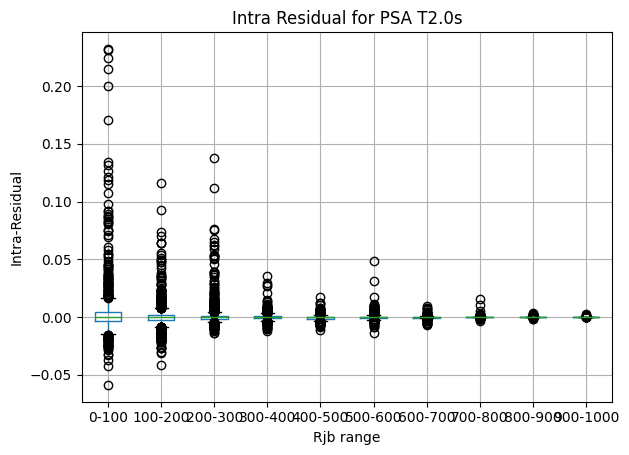

In [260]:
plt.figure(figsize=(8, 6))
new_intra.boxplot(column='T2.0', by='Rjb_range')


plt.title('Intra Residual for PSA T2.0s')
plt.suptitle('')
plt.xlabel('Rjb range')
plt.ylabel('Intra-Residual')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Intra Residual for PSA T2.0s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

<Figure size 800x600 with 0 Axes>

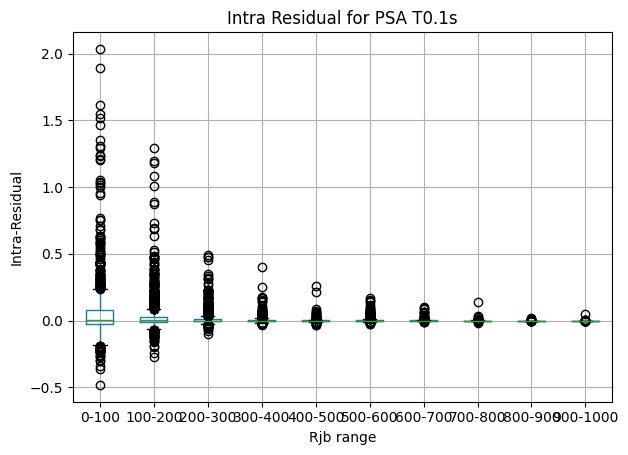

In [261]:
plt.figure(figsize=(8, 6))
new_intra.boxplot(column='T0.1', by='Rjb_range')


plt.title('Intra Residual for PSA T0.1s')
plt.suptitle('')
plt.xlabel('Rjb range')
plt.ylabel('Intra-Residual')

save_path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/PLOTS/Intra Residual for PSA T0.1s.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path)

plt.show()

<Figure size 800x600 with 0 Axes>

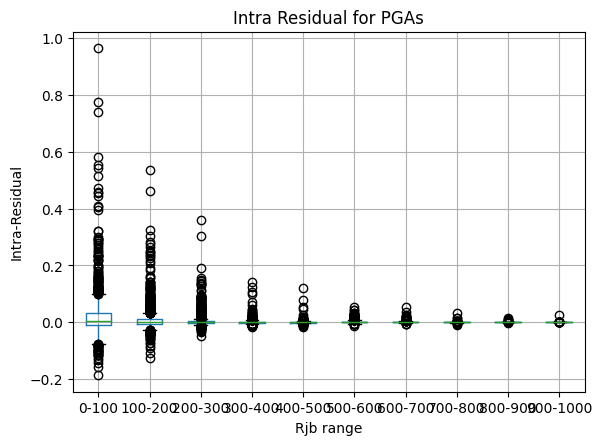

In [ ]:
plt.figure(figsize=(8, 6))
new_intra.boxplot(column='PGA', by='Rjb_range')


plt.title('Intra Residual for PGAs')
plt.suptitle('')
plt.xlabel('Rjb range')
plt.ylabel('Intra-Residual')

plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
new_intra.boxplot(column='PGA', by='Rjb_range')


plt.title('Intra Residual for PGAs')
plt.suptitle('')
plt.xlabel('Rjb range')
plt.ylabel('Intra-Residual')

plt.show()